# fbb skeleton notebook for PUI2017 HW6


In [1]:
# Run with python3
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [2]:
# Energy and PLUTO data were download and stored in PUIDATA directory

# For energy data:
# Download from https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD 
# and save csv with default name
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

# For PLUTO data dowload from here: https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip 
# unzip move to $PUIDATA 
# Subdirectory for Manhattan PLUTO data was renamed "Manhattan"
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

In [3]:
nrg.columns

Index(['BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [4]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord'

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

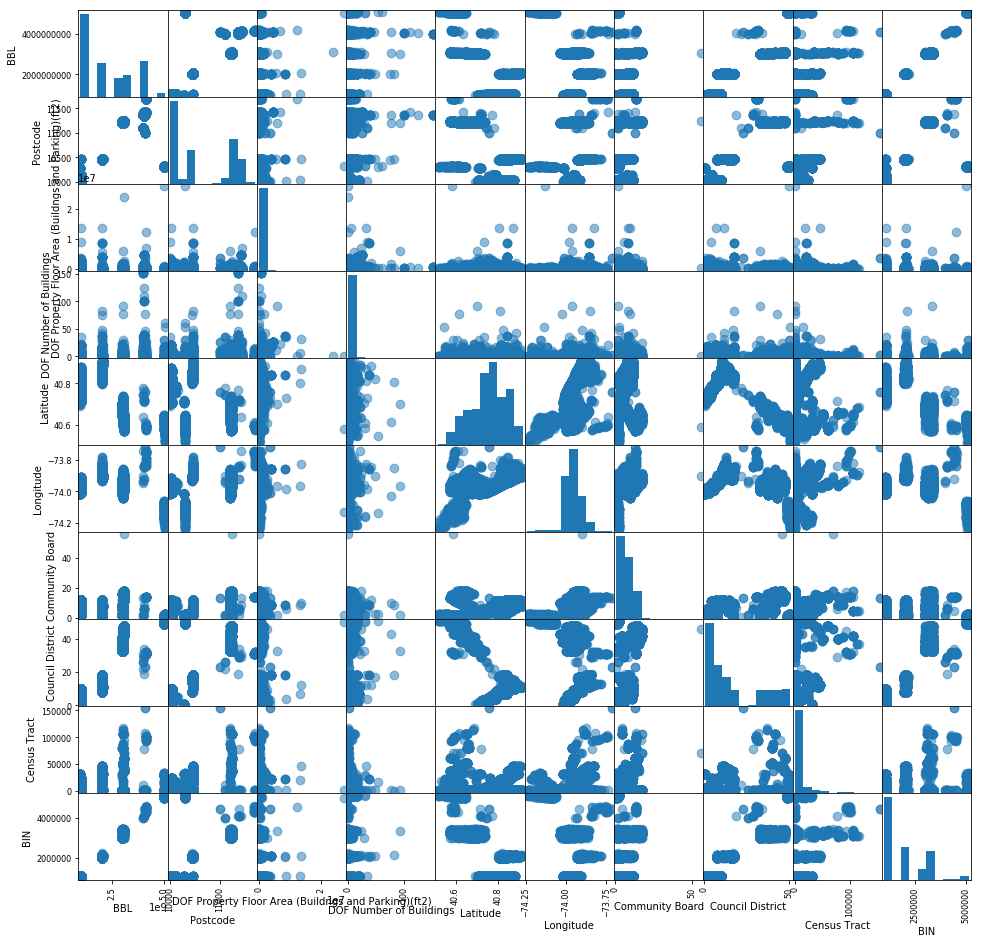

In [6]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

# I changed the imports to work with python3

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

Figure 1: scatter matrix of all numerical values in the files. The variables shown here are mostly numeric data about where building is located that I am not interested in.  It does not have the numeric data on energy usage that I want.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

### Grader comment: in the above cell, import has to be done from pandas.tools.plotting

In [7]:
# Check to see if other variables I need have numeric types
print("nrg['BBL'] dtype is "+ str(nrg['BBL'].dtype))
print("nrg['Reported Property Floor Area (Building(s)) (ft²)'] dtype is "+ 
      str(nrg['Reported Property Floor Area (Building(s)) (ft²)'].dtype))
print("bsize['BBL'] dtype is "+ str(bsize['BBL'].dtype))
print("bsize['YearBuilt'] dtype is "+ str(bsize['YearBuilt'].dtype))
print("bsize['UnitsRes'] dtype is "+ str(bsize['UnitsRes'].dtype))
print("bsize['UnitsTotal'] dtype is "+ str(bsize['UnitsTotal'].dtype))


nrg['BBL'] dtype is float64
nrg['Reported Property Floor Area (Building(s)) (ft²)'] dtype is object
bsize['BBL'] dtype is float64
bsize['YearBuilt'] dtype is int64
bsize['UnitsRes'] dtype is int64
bsize['UnitsTotal'] dtype is int64


In [8]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
#print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
#bsize.BBL.astype(float)
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

In [9]:
# Convert Building EUI  per square foot
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors = 'coerce')
# Convert Property square footage to numeric
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(
    nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors = 'coerce')
 

# Check to make sure it is converted to numeric
print (nrg['Site EUI(kBtu/ft2)'].astype(float).head())
print (nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float).head())

Record Number
12086   NaN
14354   NaN
12150   NaN
12590   NaN
15591   NaN
Name: Site EUI(kBtu/ft2), dtype: float64
Record Number
12086    918919.0
14354         NaN
12150     64200.0
12590         NaN
15591     50000.0
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64


In [10]:
#drop everything you do not need to lighten the memory load on your machine! this is important!! 
#this file has a lot of columnsm most of them you will not need

In [11]:
nrg.drop(['Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'], axis=1, inplace=True)
bsize.drop(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'Version', 'MAPPLUTO_F', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'], axis=1, inplace=True)

In [12]:
#How many missing values?
# nrg['Site EUI(kBtu/ft2)']
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("For 'Site EUI(kBtu/ft2)' : invalid entries changed to NaN %d"%sum(indx))
indx = np.isnan(nrg['Reported Property Floor Area (Building(s)) (ft²)']).sum()
print ("For 'Reported Property Floor Area (Building(s)) (ft²)' : invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

For 'Site EUI(kBtu/ft2)' : invalid entries changed to NaN 4623
For 'Reported Property Floor Area (Building(s)) (ft²)' : invalid entries changed to NaN 3125


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [13]:
# The columns were already named BBL in the data I downloaded
# Changes have probabily occured since the skeleton notebook was written in 2016
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

(5062, 5)

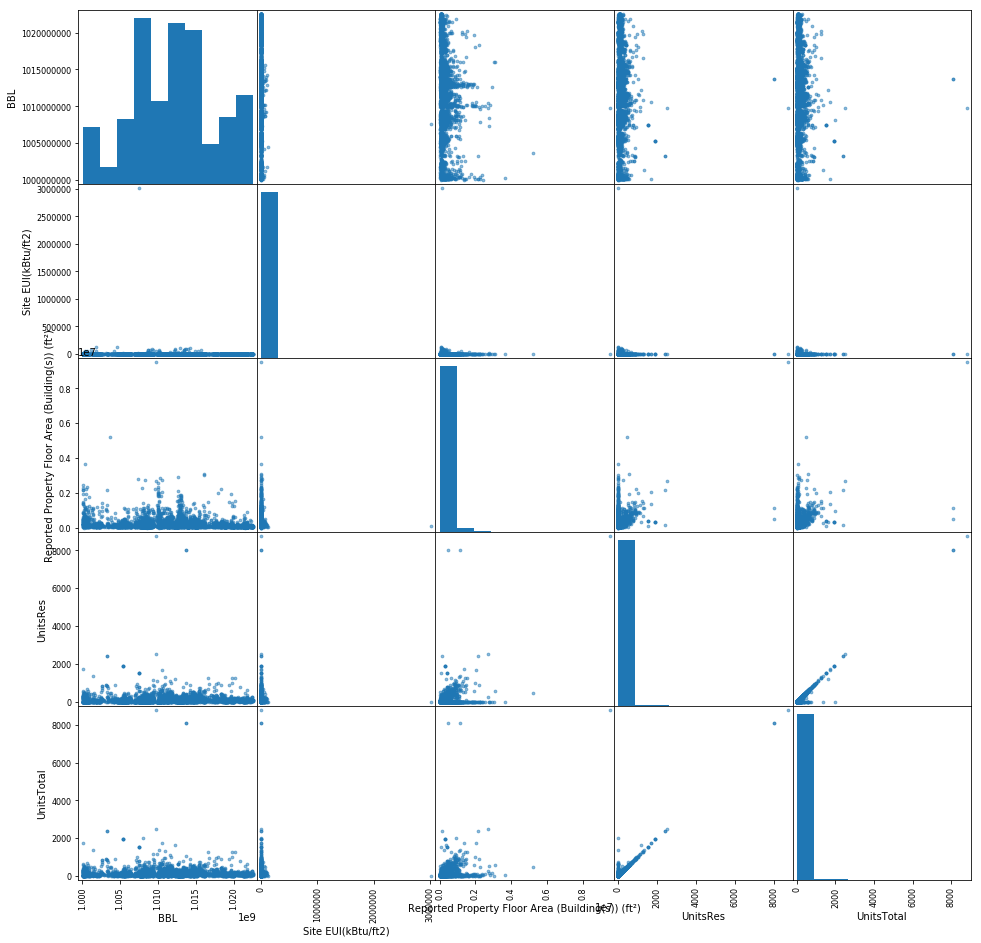

In [14]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));


Figure 2: scatter matix of final dataset. Here are the distributions of BBL, energy usage at each size, the buildingsqaure footage, number of residential units and to

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

Text(0.5,1,'Site Energy Usage vs. Number of Units in Building')

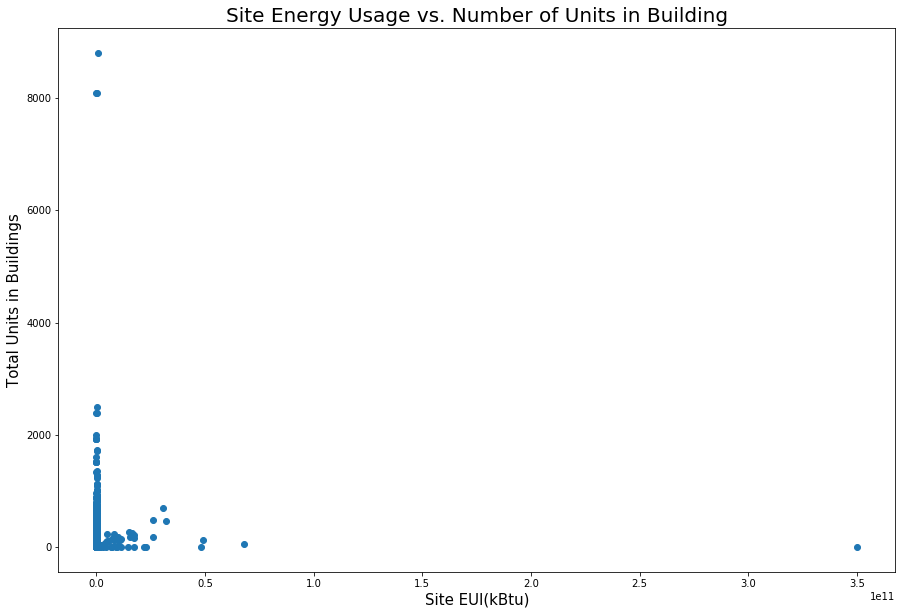

In [15]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
pl.plot(bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'],
        bblnrgdata['UnitsTotal'], "o" )
pl.xlabel('Site EUI(kBtu)', fontsize = '15')
pl.ylabel('Total Units in Buildings', fontsize = '15')
plt.title('Site Energy Usage vs. Number of Units in Building', fontsize =20)

Figure 3: Scatter Plot of site energy usage vs. number of units in building with all data shown

(0, 1000)

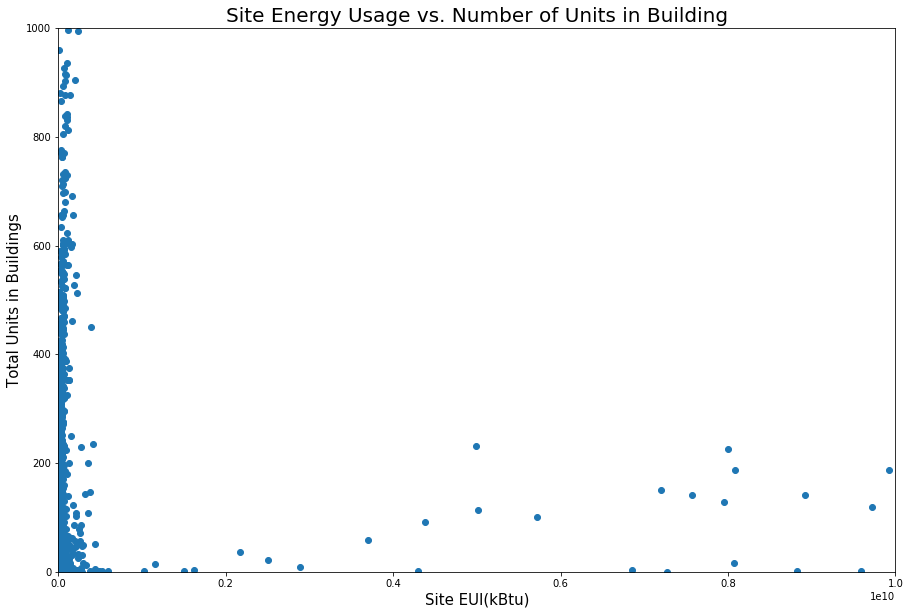

In [16]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
pl.plot(bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], 
        bblnrgdata['UnitsTotal'], "o" )
pl.xlabel('Site EUI(kBtu)', fontsize = '15')
pl.ylabel('Total Units in Buildings', fontsize = '15')
pl.title('Site Energy Usage vs. Number of Units in Building', fontsize =20)
pl.xlim(0, 1.0e+10)
pl.ylim(0, 1000)

Figure 4: Scatter Plot of site energy usage vs. number of units in building zoomed in on smaller region without outliers

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [17]:
#you may need to change the name of this column under some versions of pandas
#(ft²) may throw an error due to the funny character depending on encoding
bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

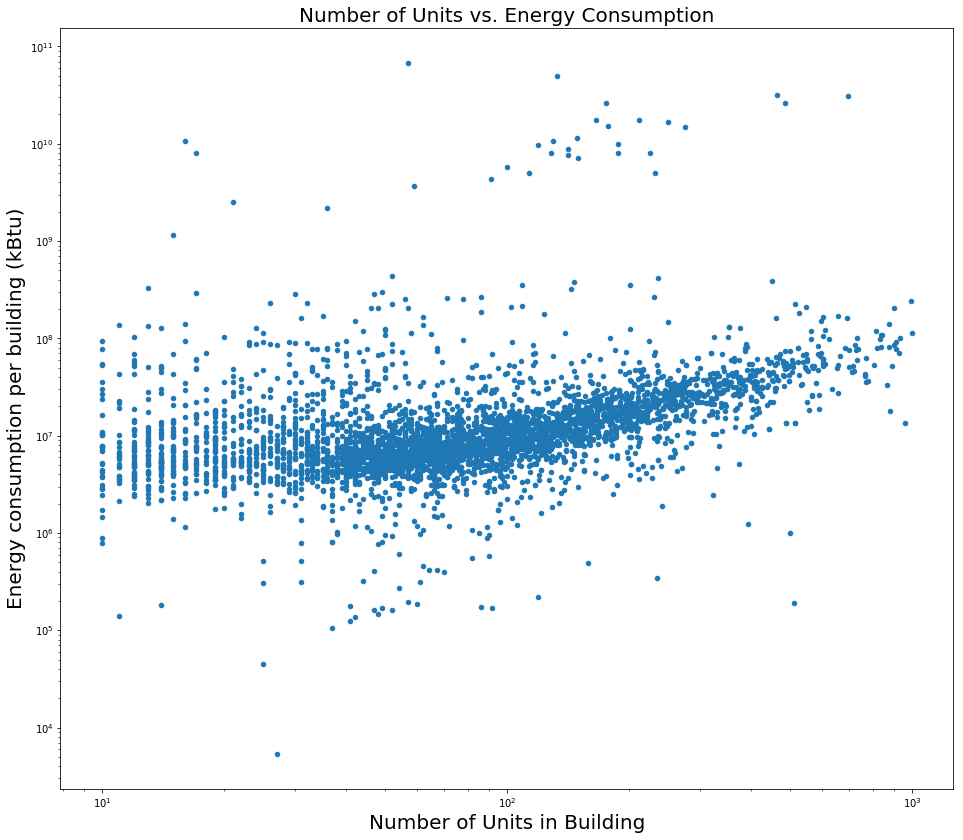

In [18]:
# I have the energy per sq foot in the data, I need the total energy though
bblnrgdata['nrg'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Reported Property Floor Area (Building(s))']

bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) & (bblnrgdata.UnitsTotal>=10) & 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='nrg', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
main_title = ax.set_title("Number of Units vs. Energy Consumption", fontsize=20)

Figure 5: Scatter Plot of site number of units  vs. energy usage in building on log10 scale for both axis with outliers removed

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 




1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



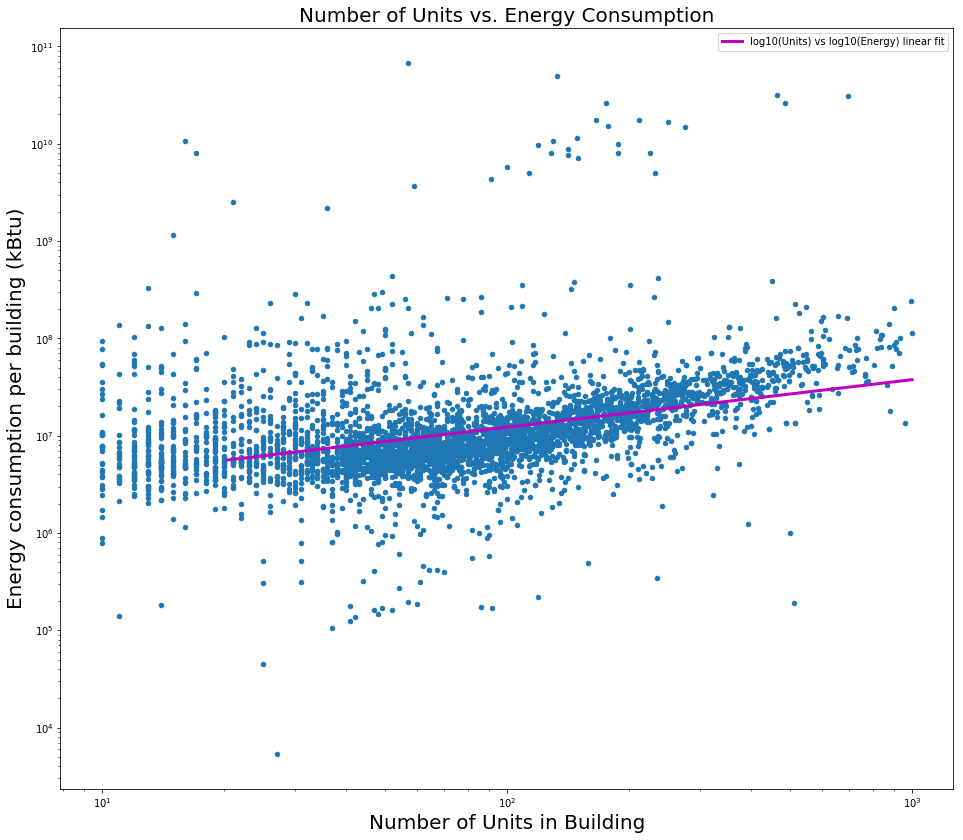

In [19]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
# Make sure your model for the quadratic fit looks right: dont just join the points, you need to sort them first!

#1. Fit a line to Units vs Energy.

# First have Units Total as the independent variable and energy consumption per building as dependent variable
X = sm.add_constant(np.log10(bblnrgdataCut['UnitsTotal']))
Y = np.log10(bblnrgdataCut['nrg'])
linmodel_1 = sm.OLS(Y, X, missing='drop').fit() # ignores entires where x or y is NaN
#print(linmodel_1.params)
dummy_x = np.linspace(0, 1000)
#plotting with first model
ax = bblnrgdataCut.plot(kind='scatter', y='nrg', x='UnitsTotal',
                        marker='o',  figsize=(16, 14), loglog=True)
xl = ax.set_xlabel("Number of Units in Building", fontsize=20)
yl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
main_title = ax.set_title("Number of Units vs. Energy Consumption", fontsize=20)

model_line = ax.plot(dummy_x, ((10 ** linmodel_1.params[0]) * (dummy_x ** linmodel_1.params[1])),
                     '-m',linewidth=3.0, label = 'log10(Units) vs log10(Energy) linear fit')
legen = ax.legend()

Figure 6: Scatter Plot of site number of units  vs. energy usage in building on log10 scale for both axis with outliers removed and a first degree linear fit plotted in pink

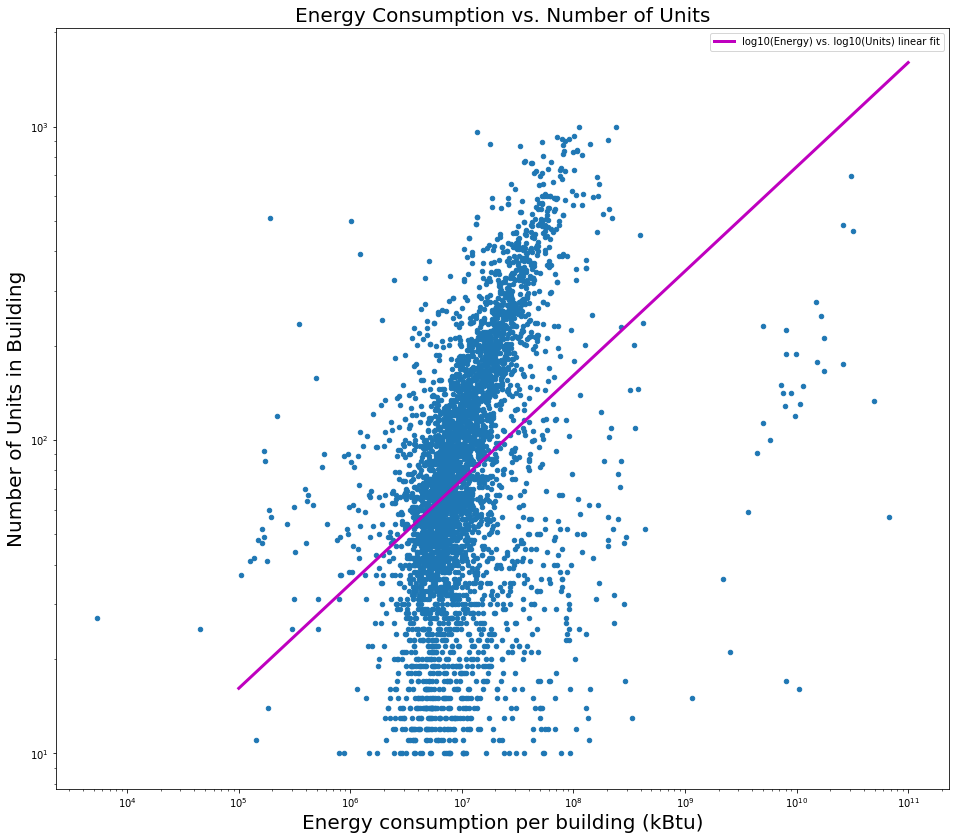

In [20]:
#2 .Fit a line  to Energy vs Units

# Second have energy consumption as the independent variable and Units Total per building as dependent variable
X = sm.add_constant(np.log10(bblnrgdataCut['nrg']))
Y = np.log10(bblnrgdataCut['UnitsTotal'])
linmodel_2 = sm.OLS(Y, X, missing='drop').fit() # ignores entires where x or y is NaN
dummy_x = np.linspace(10e4, 10e10, 100)


#plotting with first model
ax = bblnrgdataCut.plot(kind='scatter', y='UnitsTotal', x='nrg',
                        marker='o',  figsize=(16, 14), loglog=True)
xl = ax.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)
yl = ax.set_ylabel("Number of Units in Building", fontsize=20)
main_title = ax.set_title("Energy Consumption vs. Number of Units", fontsize=20)
# y = 10^b * x^a
model_line = ax.plot(dummy_x, ((10 ** linmodel_2.params[0]) * (dummy_x ** linmodel_2.params[1])), 
                     '-m',linewidth=3.0, label = 'log10(Energy) vs. log10(Units) linear fit')
legen = ax.legend()

Figure 7: Scatter Plot of site energy usage vs. number of units in building on log10 scale for both axis with outliers removed and a first degree linear fit plotted in pink

In [21]:
# Lets look at the summaries of our 2 models
print('Summary for Units vs Energy')
print(linmodel_1.summary())

print('Summary for Energy vs Units')
print(linmodel_2.summary())

# We cannot use a likelihood ratio test to compare these two models since hey are not nested.

Summary for Units vs Energy
                            OLS Regression Results                            
Dep. Variable:                    nrg   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          2.05e-166
Time:                        19:09:10   Log-Likelihood:                -2563.5
No. Observations:                4266   AIC:                             5131.
Df Residuals:                    4264   BIC:                             5144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1110   

The $R^2$ of the fits stay the same when switching which variable is being fit to which.

In [22]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [23]:
#3. Calculate chi-sq for both models

# For units vs energy
cs = chi2(np.log10(bblnrgdataCut['nrg']), linmodel_1.predict(sm.add_constant(np.log10(bblnrgdataCut['UnitsTotal']))), 
         errors = np.sqrt(np.log10(bblnrgdataCut['nrg'])))
print("Chi-sq of units vs energy model " + str(cs))

# For energy vs units
cs = chi2(np.log10(bblnrgdataCut['UnitsTotal']), linmodel_2.predict(np.log10(sm.add_constant(bblnrgdataCut['nrg']))),
        errors = np.sqrt(np.log10(bblnrgdataCut['UnitsTotal'])))
print("Chi-sq of energy vs units model " + str(cs))


# We cannot use a likelihood ratio test to compare these two models since hey are not nested.

Chi-sq of units vs energy model 110.078511334
Chi-sq of energy vs units model 1019.67484805


The chi-sq statistic for the energy vs units model is much higher.  I think this is because the values for units are on a smaller scale than the values for energy so the amount the model is off by is smaller even though it's really just flipping the axis the line is drawn through on the log10 scale.

In [24]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
#errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area'])**2 +\
#                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
#errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log

# I commented the code out since I have set up my bblnrgdataCut df differently

#4
The reason that the two values are being taken into account for the error is that nrg is a value created from 2 other values.  The errorsnrg value is created by taking the geometric mean of the square footage and the site energy usage per square foot.

propagation of errors on 

the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [25]:
#5 Fit a 2nd degree polynomial to the Units vs Energy


X = sm.add_constant(np.log10(bblnrgdataCut['UnitsTotal']))
Y = np.log10(bblnrgdataCut['nrg'])
df_model = pd.concat([X, Y], axis=1)
df_model.columns = ['a', 'X', 'Y']
linmodel_poly = smf.ols(formula="Y ~ X + I(X ** 2)", data=df_model).fit()

linmodel_poly.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     617.1
Date:                Sun, 03 Dec 2017   Prob (F-statistic):          4.37e-236
Time:                        19:09:43   Log-Likelihood:                -2399.4
No. Observations:                4266   AIC:                             4805.
Df Residuals:                    4263   BIC:                             4824.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.0824      0.111     72.620      0.000         7.864     8.301
X             -1.6820      0.119    -14.175      0.000        -1.915    -1.449
I(X ** 2)      0.5710      0.031     18.465      0.000         0.510     0.632
==============================================================================
Omnibus:                     2411.825   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59289.371
Skew:                           2.208   Prob(JB):                         0.00
Kurtosis:                      20.722   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Now Compare the second degree fit the to nested first degree fit with a likelihood ratio test
# linmodel_1 is the least complex
LR = -2 * (linmodel_1.llf - linmodel_poly.llf)
print('The likelihood ratio of the 2nd degree polynomial fit to the first degree fit is ' + str(LR))

# check my result
print(linmodel_poly.compare_lr_test(linmodel_1))
# They are the same (328.25) looks good!

The likelihood ratio of the 2nd degree polynomial fit to the first degree fit is 328.25131092
(328.25131091974436, 2.3102405124997406e-73, 1.0)


Since 328.25 is far above 3.84 (value for chi-sq corresponding to p-val of 0.05 with 1 degree of freedom)  we can say that the second the degree fit is preferable to the first degree fit. 

GRade: 8/10 - error in importing scatter matrix, and plot for 2-degree polynomial missing